In [20]:
import sklearn
import pandas as pd
import numpy as np
import math
import warnings
# plotting
import seaborn as sns
from matplotlib import pyplot 
import matplotlib.pyplot as plt
sns.set(context='paper', style='whitegrid', rc={'figure.facecolor':'white'}, font_scale=1.2)

# preproc
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# modeling
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# grid search CV for model tuning
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold

# metrics for classification
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import recall_score, precision_score, average_precision_score
from sklearn.metrics import accuracy_score, f1_score, brier_score_loss
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.metrics import make_scorer, auc

# post-processing 
from sklearn.calibration import calibration_curve
from sklearn.calibration import CalibratedClassifierCV


# statistical reporting
import statsmodels.api as sm
from sklearn.utils import resample


# import custom functions from my package
import sys
import os
sys.path.append("../")
from mcc_metastasis import modeling 
from mcc_metastasis import custom_plots
from mcc_metastasis import data_cleaning as dc

RANDOM = 0
figure_path = "../figures/NCDB_final_model/"

def missingness_table(df) :
    total = df.isnull().sum().sort_values(ascending = False)
    percent = (df.isnull().sum()/df.isnull().count()*100).round(2).sort_values(ascending = False)
    missing_data  = pd.concat([total, percent], axis=1, keys=['N missing', '% missing'])
    return(missing_data)


## Inspect data

In [12]:
 
df = pd.read_csv("../data/cleaned/NCDB_cleaned_all_cases.csv") 

# fix up some features
df['AGE'] = df.AGE.astype('float')
df['TNM_negative'] = df.TNM_positive.replace({0:1, 1:0})
df['tumor_site'] = df.tumor_site.astype("category")




### Filter data for features of interest
- 7 features: age, sex, tumor size, tumor site, growth pattern, lymphocytes, LVI
- check missingness across all available data

In [21]:

# select only features for analysis
df = df[['TNM_negative', 'AGE', 'tumor_size', 'tumor_site', 'SEX', 
              'growth_pattern', 'tumor_lymphocytes', 'lymph_vasc_invasion']]

# check missingness and save to table
missingness_table(df).to_csv("../tables/full_missingness_table.csv")
missingness_table(df)


,N missing,% missing
growth_pattern,1998,69.21
tumor_lymphocytes,1555,53.86
tumor_size,263,9.11
lymph_vasc_invasion,0,0.00
SEX,0,0.00
tumor_site,0,0.00
AGE,0,0.00
TNM_negative,0,0.00


### Filter data for only cases with valid outcome 
- check missingness

In [22]:
# only include valid cases for outcome
print("Total for MCC: %0.f" % len(df))
df = df[(df.TNM_negative.notnull())]
print("Total N with outcome: %0.f" % len(df))
df_complete = df.dropna(axis = 0)
print("Complete cases: %0.f" % len(df_complete))
missingness_table(df)

Total for MCC: 2887
Total N with outcome: 2887
Complete cases: 669


,N missing,% missing
growth_pattern,1998,69.21
tumor_lymphocytes,1555,53.86
tumor_size,263,9.11
lymph_vasc_invasion,0,0.00
SEX,0,0.00
tumor_site,0,0.00
AGE,0,0.00
TNM_negative,0,0.00


### Decide which variables to impute
-  don't want to impute 80% of LVI and TL...

In [23]:

df = df[(df.TNM_negative.notnull()) & (df.lymph_vasc_invasion.notnull())]
print("Total N with outcome and LVI: %0.f" % len(df))
df_complete = df.dropna(axis = 0)
print("Complete cases: %0.f" % len(df_complete))

missingness_table(df).to_csv("../tables/N2887_missingness_table_to_impute.csv")
missingness_table(df)

Total N with outcome and LVI: 2887
Complete cases: 669


,N missing,% missing
growth_pattern,1998,69.21
tumor_lymphocytes,1555,53.86
tumor_size,263,9.11
lymph_vasc_invasion,0,0.00
SEX,0,0.00
tumor_site,0,0.00
AGE,0,0.00
TNM_negative,0,0.00


## Preprocessing
### One-hot encode tumor site 
- one-hot encode categorical features
-- tumor site: dropping one level as reference (extremity)


In [24]:
one_hot_tumor_site = pd.get_dummies(df.tumor_site, prefix = 'tumor_site', drop_first =True)
df = df.drop(columns = ['tumor_site'])
df = pd.concat([df, one_hot_tumor_site], axis = 1)



### Impute data 
- needs to be outside pipeline for now, since imputation provides non-binary values
- add as custom preproc step later

In [26]:

# split up data 
outcome = df['TNM_negative'].reset_index(drop = True)
features = df.drop(columns = 'TNM_negative')

## impute
imputer = IterativeImputer(max_iter=10, random_state=0)
imputed_features =  pd.DataFrame(imputer.fit_transform(features), columns = features.columns)
imputed_df = pd.concat([imputed_features, outcome], axis = 1)
imputed_df.head()

,AGE,tumor_size,SEX,growth_pattern,tumor_lymphocytes,lymph_vasc_invasion,tumor_site_head_neck,tumor_site_other,tumor_site_trunk,TNM_negative
0,71.0,1.0,1.0,0.284245,0.274179,0.0,1.0,0.0,0.0,1.0
1,59.0,2.5,0.0,0.268583,0.308079,0.0,0.0,0.0,0.0,1.0
2,90.0,1.5,1.0,0.313679,0.283550,0.0,0.0,0.0,0.0,1.0
3,58.0,0.5,1.0,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0
4,53.0,1.7,1.0,0.251498,0.355273,0.0,0.0,0.0,0.0,0.0


In [27]:
imputed_df.tumor_size.value_counts()

2.000000     258
1.000000     235
1.500000     148
0.500000     118
0.600000     113
            ... 
1.758647       1
12.700000      1
1.540144       1
1.542694       1
7.300000       1
Name: tumor_size, Length: 318, dtype: int64

In [28]:
imputed_df.tumor_lymphocytes.value_counts()

0.000000    862
1.000000    470
0.287929      4
0.317781      4
0.341049      3
           ... 
0.333002      1
0.329935      1
0.335053      1
0.215757      1
0.296018      1
Name: tumor_lymphocytes, Length: 1442, dtype: int64

In [29]:
# binarize imputed variable !! 
imputed_features['tumor_lymphocytes'] = imputed_features.tumor_lymphocytes.\
apply(lambda x : 1 if x > 0.5 else 0)
imputed_features.lymph_vasc_invasion.value_counts()

0.0    1958
1.0     929
Name: lymph_vasc_invasion, dtype: int64

In [30]:
#imputed_features.growth_pattern.value_counts()
# binarize imputed variable !! 
imputed_features['growth_pattern'] = imputed_features.growth_pattern.\
apply(lambda x : 1 if x > 0.5 else 0)

imputed_features.growth_pattern.value_counts()

0    2557
1     330
Name: growth_pattern, dtype: int64

### Standardizing numeric features
- standard scale (zscore) numeric, continuous features
- using pipeline so that each sub-sample is standardized separately!

In [33]:
# DEFINE PREPROCESSING 
num_features = ['AGE', 'tumor_size']
all_features = features.columns

# Build a preprcessing pipeline for numeric variables
num_pipeline = Pipeline(steps=[
    ('std_scaler', StandardScaler())])
    # Build a preprocessing pipeline for categorical variables

# Instantiate a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
    ("num", num_pipeline, num_features)],
    remainder = 'passthrough')

preproc_basic = Pipeline(steps = [('preproc', preprocessor)])

## ML pipeline 

### Set up logistic regression
- with 2 types of calibration and cross-validation

In [34]:
# define CV folds                                                       
CV_folds =  RepeatedStratifiedKFold(n_splits = 3, 
                                    n_repeats =  5,  
                                    random_state = 0)
# define logisic reg
LR_model = LogisticRegression(class_weight = 'balanced', 
                              max_iter = 1000,
                              penalty = 'l1', 
                               C = 10,
                              solver = 'liblinear', 
                             random_state = 0)

# add extra step of calibration 
Isotonic = CalibratedClassifierCV(LR_model, method = "isotonic", cv = CV_folds)
Sigmoid = CalibratedClassifierCV(LR_model, method = "sigmoid", cv = CV_folds)

# define scores to get from each model 
def get_scores(y_test, y_pred):
        scores = pd.DataFrame({ "metrics"  : ["precision", "recall", "roc_auc",
                                          "accuracy", "f1 score", "pr_auc", "brier_score"],
                                "scores" : [precision_score(y_test, y_pred), 
                                           recall_score(y_test, y_pred),
                                            roc_auc_score(y_test, y_pred),
                                            accuracy_score(y_test, y_pred),
                                           f1_score(y_test, y_pred), 
                                           average_precision_score(y_test, y_pred), 
                                           brier_score_loss (y_test, y_pred)]
                               })
        scores['scores'] = scores.scores.round(3)
        return (scores)


#### Set up train-test splits
- stratified by metastasis outcome 

In [35]:
# split into train and test set 
X_trainval, X_test, y_trainval, y_test = train_test_split(imputed_features, 
                                                              outcome,
                                                              stratify =outcome,
                                                              test_size = 0.35, 
                                                             random_state = 0)
    # further split so only doing CV on the training, validattion for ccalibration
X_train, X_val, y_train, y_val = train_test_split(X_trainval,
                                                     y_trainval,
                                                     stratify = y_trainval, 
                                                     test_size = 0.25, 
                                                     random_state = 0)
print("Training N: %0.f" % len(X_train))
print("Validation N: %0.f" % len(X_test))
print("Test N: %0.f" % len(X_test))

Training N: 1407
Validation N: 1011
Test N: 1011


#### Run model training and compare scores

In [71]:
# preproc by hand beccause pipeline doesn't wrk with calibrated classifier      
X_train_preproc = preproc_basic.fit_transform(X_train)
X_val_preproc = preproc_basic.fit_transform(X_val)
X_test_preproc = preproc_basic.fit_transform(X_test)

LR_model.fit(X_train_preproc, y_train)        
Sigmoid.fit(X_train, y_train)        
Isotonic.fit(X_train, y_train)        

AttributeError: 'LogisticRegression' object has no attribute 'scores_'

In [68]:

# fit regular model 
LR_model.fit(X_train_preproc, y_train)        
LR_y_val_probs = LR_model.predict_proba(X_val_preproc)[:,1]
LR_y_val_pred = LR_model.predict(X_val_preproc)
LR_scores = pd.DataFrame(get_scores(y_val, LR_y_val_pred))
LR_scores['model'] = 'LR'

# with calibration
Sigmoid.fit(X_train, y_train)        
Sigmoid_y_val_probs = Sigmoid.predict_proba(X_val)[:,1]
Sigmoid_y_val_pred = Sigmoid.predict(X_val)
Sigmoid_scores = pd.DataFrame(get_scores(y_val, Sigmoid_y_val_pred))
Sigmoid_scores['model'] = 'Sigmoid'

# with calibration
Isotonic.fit(X_train, y_train)        
Isotonic_y_val_probs = Isotonic.predict_proba(X_val)[:,1]
Isotonic_y_val_pred = Isotonic.predict(X_val)
Isotonic_scores = pd.DataFrame(get_scores(y_val, Isotonic_y_val_pred))
Isotonic_scores['model'] = 'Isotonic'


In [69]:
calibrate_results = pd.concat([LR_scores, Isotonic_scores, Sigmoid_scores], ignore_index = True)
display(calibrate_results[(calibrate_results.metrics == "brier_score") | 
                         (calibrate_results.metrics == "precision")])
calibrate_results.to_csv("../tables/model_training_compare_calibration.csv")

,metrics,scores,model
0,precision,0.830,LR
6,brier_score,0.307,LR
7,precision,0.735,Isotonic
13,brier_score,0.267,Isotonic
14,precision,0.729,Sigmoid
20,brier_score,0.273,Sigmoid


**Isotonic valibration worked the best, lowest brier score, use moving forward**

#### Compare calibration results on validation set
- to visually compare best model (isotonic) with the rest

Text(0.5, 1.0, 'Calibration plots  (reliability curve)')

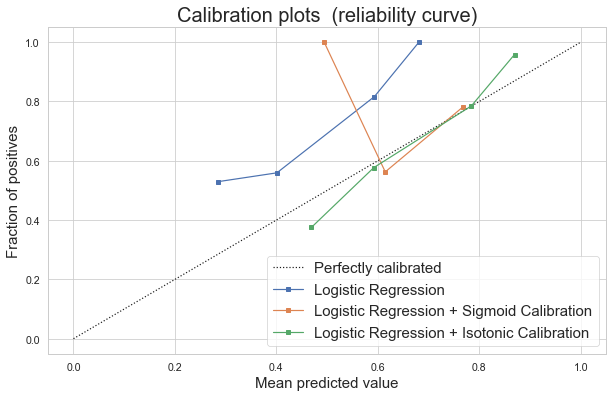

In [40]:

#figure_path = "NCDB_5_features/"
fig = plt.figure(figsize=(10, 6))
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
fraction_of_positives, mean_predicted_value = calibration_curve(y_val, LR_y_val_probs, n_bins =6)
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label = "Logistic Regression")
fraction_of_positives, mean_predicted_value = calibration_curve(y_val, Sigmoid_y_val_probs, n_bins = 6)
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label = "Logistic Regression + Sigmoid Calibration")
fraction_of_positives, mean_predicted_value = calibration_curve(y_val, Isotonic_y_val_probs, n_bins = 6)
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label = "Logistic Regression + Isotonic Calibration")

plt.xlabel("Mean predicted value", size = 15)
plt.ylabel("Fraction of positives", size = 15)
plt.ylim([-0.05, 1.05])
plt.legend(loc="lower right", fontsize = 15)
plt.title('Calibration plots  (reliability curve)', size = 20)
#plt.savefig(os.path.join(figure_path, "Calibration_validation_plot.png"))

#### Results with regular un-calibrated model with default threshold
- for comparison's sake

array([[ 76,  51],
       [ 93, 249]])

,metrics,scores
0,precision,0.830
1,recall,0.728
2,roc_auc,0.663
3,accuracy,0.693
4,f1 score,0.776
5,pr_auc,0.803
6,brier_score,0.307


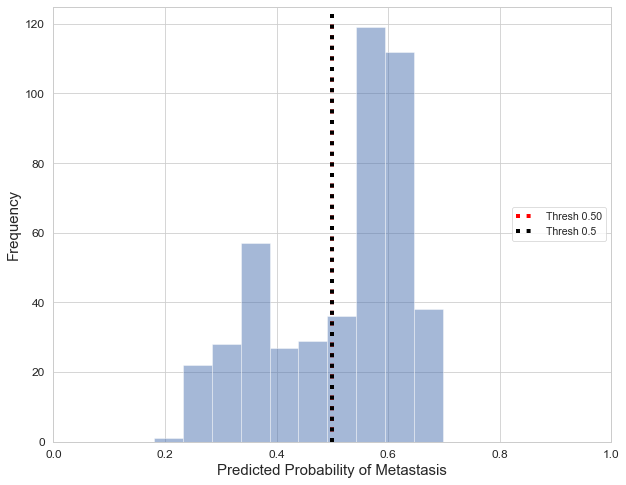

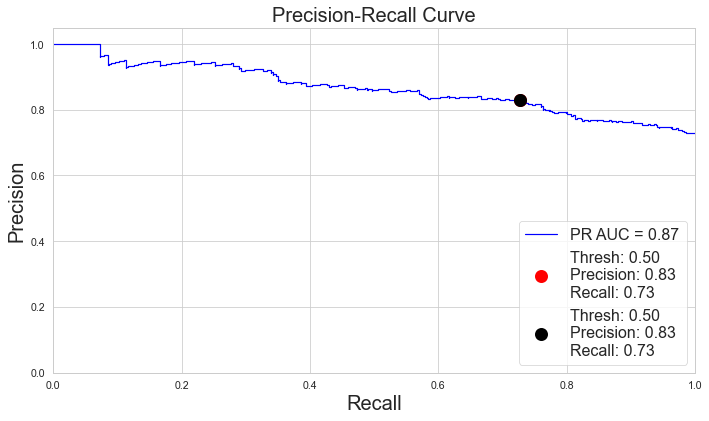

In [14]:
LR_y_val_probs = LR_model.predict_proba(X_val_preproc)[:,1]
LR_y_val_pred = LR_model.predict(X_val_preproc)

cm = confusion_matrix(y_val, LR_y_val_pred)
display(cm)
LR_val_scores = pd.DataFrame(get_scores(y_val, LR_y_val_pred))
display(LR_val_scores)

custom_plots.plot_predprobs(LR_y_val_probs, 0.5, 
                             filename = os.path.join(figure_path, "LR_predprobs.png"))
custom_plots.plot_pr_curve(y_val, LR_y_val_probs, 0.5,
               filename = os.path.join(figure_path,"LR_validation_PR_curve.png"))



### Tuning decision threshold with validation set
#### Results with isotonic calibrated model, default threshold

In [15]:
Isotonic_y_val_probs = Isotonic.predict_proba(X_val_preproc)[:,1]
Isotonic_y_val_pred = Isotonic.predict(X_val_preproc)

cm = confusion_matrix(y_val, Isotonic_y_val_pred)
display(cm)
val_scores = pd.DataFrame(get_scores(y_val, Isotonic_y_val_pred))
display(val_scores)

print("Range of probabilities: %0.3f - %0.3f" % (min(Isotonic_y_val_probs), max(Isotonic_y_val_probs)))

array([[ 24, 103],
       [ 21, 321]])

,metrics,scores
0,precision,0.757
1,recall,0.939
2,roc_auc,0.564
3,accuracy,0.736
4,f1 score,0.838
5,pr_auc,0.755
6,brier_score,0.264


Range of probabilities: 0.280 - 0.823


#### results with isotonic calibrated model, adjusted threshold

array([[ 97,  30],
       [159, 183]])

,metrics,scores
0,precision,0.859
1,recall,0.535
2,roc_auc,0.649
3,accuracy,0.597
4,f1 score,0.659
5,pr_auc,0.799
6,brier_score,0.403


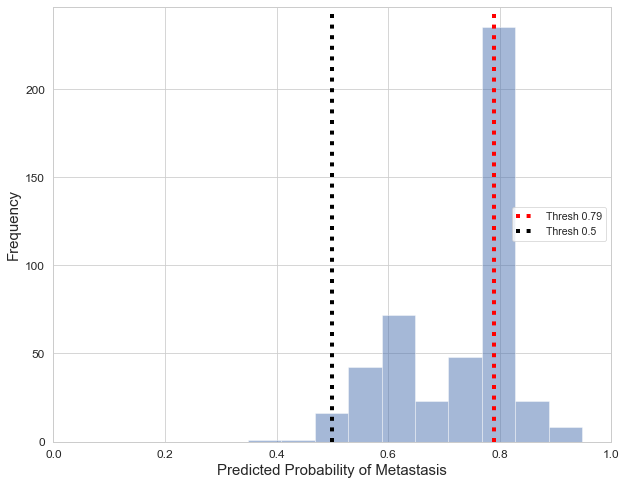

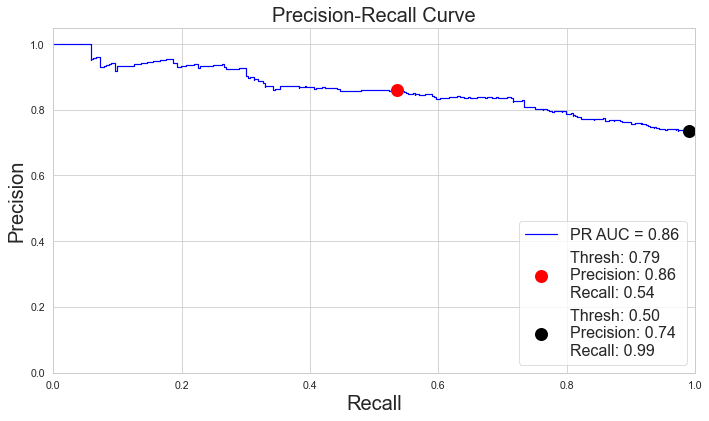

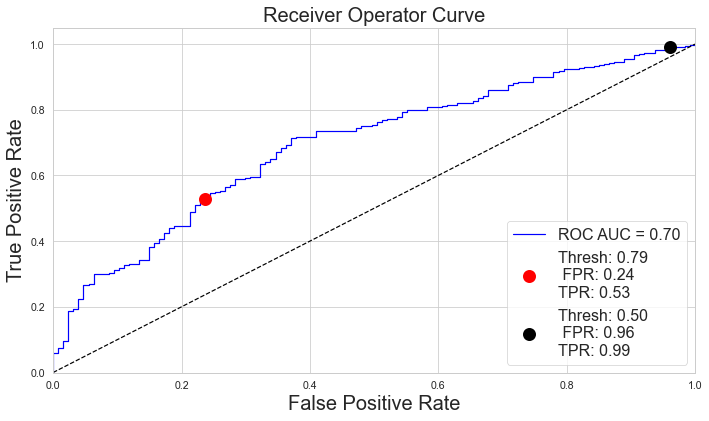

In [64]:
key_thresh = 0.79

Isotonic_y_val_pred_adjusted =  Isotonic_y_val_probs > key_thresh
cm = confusion_matrix(y_val, Isotonic_y_val_pred_adjusted)
display(cm)
val_scores_adjusted = pd.DataFrame(get_scores(y_val, Isotonic_y_val_pred_adjusted))
val_scores_adjusted.to_csv("../tables/calibrated_model_scores_validation_keythresh.csv")
display(val_scores_adjusted)

custom_plots.plot_predprobs(Isotonic_y_val_probs, key_thresh, 
                             filename = os.path.join(figure_path, "predprobs.png"))
custom_plots.plot_pr_curve(y_val, Isotonic_y_val_probs, key_thresh,
               filename = os.path.join(figure_path,"validation_PR_curve.png"))
custom_plots.plot_roc_curve(y_val, Isotonic_y_val_probs, key_thresh, 
                           filename = os.path.join(figure_path,"validation_ROC_curve.png"))

### Get Feature importance 
#### obtain feature names from preprocessed data
- note: tumor_site was dummy-encoded, with "Extremity" as the reference.
- preprocessor changes order of variables

In [44]:

# get new feature order frorm preprocessor
preproc_feature_order = pd.DataFrame(modeling.get_feature_names(preprocessor))
preproc_feature_order.columns = ['variable']
preproc_feature_order['num'] = np.arange(start = 0, stop = 9, step = 1).astype('str')
preproc_feature_order['blah'] = 'x'
preproc_feature_order['index'] = preproc_feature_order.blah.str.cat(preproc_feature_order.num, sep = "")


../mcc_metastasis/modeling.py:157: UserWarning: Transformer std_scaler (type StandardScaler) does not provide get_feature_names. Will return input column names if available
  % (str(name), type(trans).__name__))


,variable,num,blah,index
0,num__AGE,0,x,x0
1,num__tumor_size,1,x,x1
2,SEX,2,x,x2
3,growth_pattern,3,x,x3
4,tumor_lymphocytes,4,x,x4
5,lymph_vasc_invasion,5,x,x5
6,tumor_site_head_neck,6,x,x6
7,tumor_site_other,7,x,x7
8,tumor_site_trunk,8,x,x8


#### Bootstrap resampling for coefficient estimates
- using bootstrap resampling to get empirical quantiles for 95% CI 
- not using parametric estimates from SE, because w non-parametric bootstrap, inflated estimates... 


In [45]:
# use data frrom your training sample, need to combine to match the X and Y together
X_train_df = pd.DataFrame(X_train).reset_index(drop = True)
y_train_df = pd.DataFrame(y_train).reset_index(drop = True)
data = pd.concat([X_train_df, y_train_df], axis = 1)
# set up lloop 
n_iterations = 1000
n_size = int(data.shape[0])
print("Training sample size for bootstrap: %0.f" % n_size)


Training sample size for bootstrap: 1407


In [46]:
# side note: calculate mean ages for app 
print(X_train_df.AGE.mean())
print(X_train_df.tumor_size.mean())

73.40724946695096
2.0111948113403963


In [47]:
# run bootstrap
stats = pd.DataFrame()
for i in range(n_iterations):
    # prepare boostrap sample with resampling, and make sure you stratify!
    train = resample(data, n_samples = n_size, replace = True, stratify = data['TNM_negative'])
    X_train_boot = pd.DataFrame(train.iloc[:, :-1],  columns = X_train_df.columns)
    y_train_boot = train.iloc[:, -1] # last collumns

    # get out-of-bag estimates to test, find rows that weren't included in the train sample
    test = np.array([x for x in data.to_numpy() if x.tolist() not in train.to_numpy().tolist()])
    X_test_boot = pd.DataFrame(test[:, :-1],  columns = X_train_df.columns)
    y_test_boot = pd.DataFrame(test[:, -1]).astype('float') # last column 
    
    # apply preprocessing to your bootstrap sample
    preproc_X_train_boot = preproc_basic.fit_transform(X_train_boot)
    # fit model
    model = LR_model
    model.fit(preproc_X_train_boot, y_train_boot)

    
    #print(classification_report(y_test_boot, y_pred_boot))
    coefs = pd.DataFrame(model.coef_.T)
    stats = pd.concat([stats, coefs], axis = 1)


In [50]:
# calculate CI 
upper_CI_q = pd.DataFrame()
lower_CI_q = pd.DataFrame()

for i in range(stats.shape[0]):
   # print(i)
    coef_row = stats.iloc[i, :]
    # calculate empirical quantiles 
    CI_quantile = (coef_row).quantile([0.025, 0.975])
    upper_q = pd.Series(CI_quantile.iloc[1])
    lower_q = pd.Series(CI_quantile.iloc[0])
    upper_CI_q = pd.concat([upper_CI_q, upper_q], axis = 0, ignore_index = True)
    lower_CI_q = pd.concat([lower_CI_q, lower_q], axis = 0, ignore_index = True)
    

In [56]:
# make summary table 
stats_summary = pd.DataFrame()
stats_summary['features'] =  preproc_feature_order.variable.replace({'num__AGE': 'age',
                                                                     'num__tumor_size':'tumor_size',
                                                                     'SEX': 'sex'})
stats_summary['mean'] = stats.mean(axis = 1)
stats_summary['upper'] = upper_CI_q
stats_summary['lower'] = lower_CI_q
# these are empirical CI, so instead of standard error, 
# the CI are not symmetrical necessarily 
stats_summary['lower_error'] = stats_summary['mean'] -stats_summary['lower']
stats_summary['upper_error'] = stats_summary['upper'] - stats_summary['mean']


In [58]:
# make it even prettier 
pretty_feature_names = { 'tumor_size': 'Tumor size',
                         'age': 'Age',
                          'sex': 'Sex', 
                          'growth_pattern': 'Growth pattern',
                          'tumor_lymphocytes': 'Tumor lymphocytes',
                          'lymph_vasc_invasion': 'Lymphatic vascular invasion', 
                          'tumor_site_head_neck' : 'Tumor site: head / neck', 
                          'tumor_site_trunk': 'Tumor site: trunk', 
                           'tumor_site_other' : 'Tumor site: other' }
stats_summary.features = stats_summary.features.replace(pretty_feature_names)
stats_summary.to_csv("../tables/model_coefs_bootstrap_CI.csv")
stats_summary

,features,mean,upper,lower,lower_error,upper_error
0,Age,0.036921,0.171307,-0.092696,0.129617,0.134386
1,Tumor size,-0.102056,0.070854,-0.344204,0.242147,0.172910
2,Sex,-0.193190,0.065113,-0.451931,0.258741,0.258303
3,Growth pattern,-0.252008,0.138968,-0.687795,0.435787,0.390976
4,Tumor lymphocytes,-0.229295,0.110746,-0.580309,0.351014,0.340041
5,Lymphatic vascular invasion,-0.916092,-0.646125,-1.197297,0.281205,0.269967
6,Tumor site: head / neck,0.009713,0.396498,-0.354790,0.364503,0.386786
7,Tumor site: other,0.196710,0.516331,-0.133723,0.330433,0.319621
8,Tumor site: trunk,-0.160140,0.279806,-0.586472,0.426331,0.439946


/Users/michellevantieghem2/.conda/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  if sys.path[0] == '':


<Figure size 720x576 with 0 Axes>

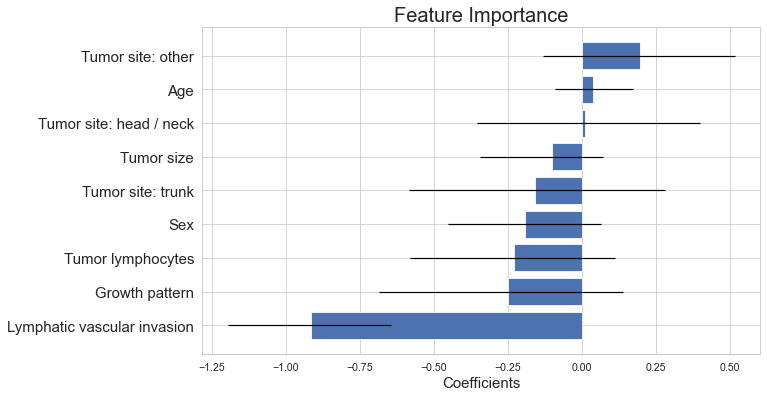

In [63]:
# get coefficients in order of importance
coefs_ordered = stats_summary.sort_values(by = 'mean', ascending = False, ignore_index = True)
n_features = coefs_ordered.shape[0]
error_values = [coefs_ordered.lower_error, coefs_ordered.upper_error]

# plot! 
filename = os.path.join(figure_path, "feature_importance_trainval_bootstrap_CI.png")
plt.figure(figsize = (10, 8))
fig, ax = plt.subplots(1,1, figsize = (10,6))
ax.barh(coefs_ordered['features'], coefs_ordered['mean'], xerr = error_values,
        align = 'center', ecolor = "black")
ax.set_yticklabels(coefs_ordered['features'], size = 15)
ax.invert_yaxis()
ax.set_xlabel("Coefficients", size = 15)
ax.set_title("Feature Importance", size = 20)
plt.savefig(filename, bbox_inches = 'tight')
plt.show()

### Evaluate final model on hold-out test set
- getting predictions on new data

,metrics,scores
0,precision,0.846
1,recall,0.485
2,roc_auc,0.623
3,accuracy,0.560
4,f1 score,0.617
5,pr_auc,0.786
6,brier_score,0.440


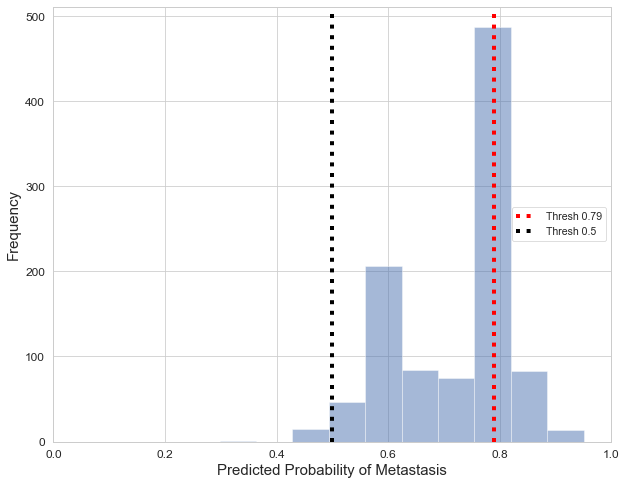

In [66]:
Isotonic_y_test_probs = Isotonic.predict_proba(X_test)[:,1]
Isotonic_y_test_pred = Isotonic.predict(X_test)
Isotonic_y_test_pred_adjusted =  Isotonic_y_test_probs > key_thresh
Isotonic_scores = pd.DataFrame(get_scores(y_test, Isotonic_y_test_pred_adjusted))
Isotonic_scores.to_csv("../tables/calibrated_model_scores_test.csv")
display(Isotonic_scores)
custom_plots.plot_predprobs(Isotonic_y_test_probs, key_thresh,
                           filename = os.path.join(figure_path, "predprobs.png"))


In [44]:
cm = confusion_matrix(y_test, Isotonic_y_test_pred_adjusted)
cm_perc = ((cm / len(y_test))*100).astype("int")

cm_perc

array([[20,  6],
       [37, 35]])

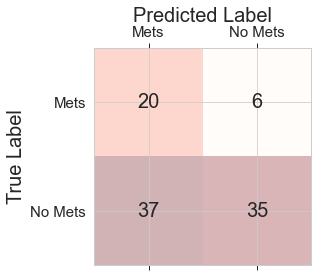

In [45]:
modeling.pretty_cm(cm_perc, os.path.join(figure_path, "Test_confusion_matrix_adjusted.png"))


In [65]:
# remember, positive class = no mets 
TN = cm[0,0]
FP = cm[0, 1]
TP = cm[1,1]
FN = cm[1,0]

print("TN: %0.f, FN: %0.f, TP: %0.f, FP: %0.f" % (TN, FN, TP, FP))
sensitivity = (TP / (TP + FN))
specificity = (TN / (TN + FP))
likelihood_ratio_no_mets = sensitivity / (1-specificity)
likelihood_ratio_mets = (1-sensitivity)/ specificity
print("Recall or sensitivity for no-mets: %0.3f" % sensitivity)
print("Specificity for no-mets: %0.3f" % specificity )
print("Likelihood ratio for no-mets:  %0.3f" %likelihood_ratio_no_mets)
print("Likelihood ratio for mets:  %0.3f" %likelihood_ratio_mets)

                     

TN: 208, FN: 380, TP: 358, FP: 65
Recall or sensitivity for no-mets: 0.485
Specificity for no-mets: 0.762
Likelihood ratio for no-mets:  2.037
Likelihood ratio for mets:  0.676


### Save the model 

In [49]:
import pickle
filename = '../model_output/final_logistic_isotonic_model.sav'
pickle.dump(Isotonic, open(filename, 'wb'))